In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import json
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import v_measure_score

from functions import join_stocks_crypto, run_clustering_model

c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
#Find stocks with over the top volatility
df_all_stocks = pd.read_csv('stocks_data_FINAL.csv',index_col='Date')
df_all_stocks.index = pd.to_datetime(df_all_stocks.index)
df_all_stocks.index = df_all_stocks.index.strftime('%Y-%m-%d')


cryptos_df = pd.read_csv('cryptos_data_new.csv', index_col='timestamp')
joined_df = join_stocks_crypto(cryptos_df, df_all_stocks, mode = 'stocks_left')
joined_df.index = pd.to_datetime(joined_df.index)

cryptos_list = list(cryptos_df.columns)

joined_df_weekly = joined_df.resample('W').last() #aggregating on a weekly level
joined_df_3days = joined_df.resample('3D').last()# aggregating on a twice per week basis to arrive at the sweet spot of that 250 (1 year) timeseries length

# log_returns = np.log(df_all_stocks / df_all_stocks.shift(1)).dropna()
# daily_volatility = log_returns.std()
# annual_volatility = daily_volatility * np.sqrt(252)

# annual_volatility.sort_values().tail(20)



# to_drop = ['XSP.F', 'C0V.F', 'OL5.F', 'SMMT', 'H2Y.F', 'GLY.F', 'LPS1.F', 'KO32.F']
# df_all_stocks = df_all_stocks.drop(columns = to_drop)
# df_all_stocks = df_all_stocks.bfill()
# df_all_stocks.to_csv('stocks_data_FINAL.csv')


CLUSTERING INSIGHTS

In [3]:
# map_region_to_country = {'cn_market': 'asia',
#  'crypto': 'crypto',
#  'dr_market': 'eu',
#  'fr_market': 'eu',
#  'gb_market': 'eu',
#  'hk_market': 'asia',
#  'jp_market': 'asia',
#  'nl_market': 'eu',
#  'us_market': 'us'}

# yf_style_crypto_tickers = [ticker.replace('USDT', '-USD') for ticker in cryptos_df.columns]

# df_all_stocks = pd.read_csv('stocks_data_FINAL.csv',index_col='Date')
# cryptos_df = pd.read_csv('cryptos_data_new.csv', index_col='timestamp')
# tickers_all = list(df_all_stocks.columns) + list(cryptos_df.columns) 

# exchanges_dict = dict()
# sector_dict = dict()
# market_dict = dict()
# region_dict = dict()
# for ticker in tickers_all:
#     dat = yf.Ticker(ticker)
#     if ticker in list(cryptos_df.columns):
#         exchanges_dict[ticker] = 'crypto'
#         sector_dict[ticker] = 'crypto'
#         market_dict[ticker] = 'crypto'
#         region_dict[ticker] = 'crypto'
#     else:
#         exchange = dat.info['exchange']
#         sector = dat.info['sectorKey']
#         market = dat.info['market']

#         exchanges_dict[ticker] = exchange
#         sector_dict[ticker] = sector
#         market_dict[ticker] = market
#         region_dict[ticker] = map_region_to_country[market]
 

# with open('tickers_with_exchanges.json', 'w') as fp:
#     json.dump(exchanges_dict, fp)

# with open('tickers_with_sectors.json', 'w') as fp:
#     json.dump(sector_dict, fp)

# with open('tickers_with_market.json', 'w') as fp:
#     json.dump(market_dict, fp)

# with open('tickers_with_region.json', 'w') as fp:
#     json.dump(region_dict, fp)

In [4]:
cluster_labels = dict()
for method in ['kshape']:#['ahc', 'kmeans', 'kshape']:
    with open(f'tickers_labels_{method}_final.json') as f:
        clusters = json.load(f)
        cluster_labels[method] = clusters


with open('tickers_with_exchanges.json') as f:
    exchanges_dict = json.load(f)

with open('tickers_with_sectors.json') as f:
    sector_dict = json.load(f)

with open('tickers_with_region.json') as f:
    region_dict = json.load(f)

with open('tickers_with_market.json') as f:
    market_dict = json.load(f)

In [24]:
df = joined_df_3days.rolling(window=1, center=False).mean()
labels, tickers_with_labels_kshape, _, _ = run_clustering_model(df, n_clus=9, model_name='kshape', linkage=None, return_mode='geometric', n_init=3)

cluster_labels['kshape'] = tickers_with_labels_kshape

In [12]:
def visualise_cryptos_in_clusters(ticker_to_class:dict, ticker_to_cluster_all, method, just_cryptos=True, heatmap=False, file_name='NO_NAME', class_name='NO_CLASS_NAME'):
    df = pd.DataFrame({
    'Ticker': list(ticker_to_class.keys()),
    'CLASS': [ticker_to_class[t] for t in ticker_to_class],
    'Cluster': [ticker_to_cluster_all[method][t] for t in ticker_to_class]
    })

    if just_cryptos:
        df = df[df['CLASS'] == 'crypto']

    pivot = df.groupby(['Cluster', 'CLASS']).size().unstack(fill_value=0)
    
    if heatmap:
        sns.heatmap(pivot, annot=True, fmt='d', cmap='YlGnBu')
        plt.title('Heatmap of CLASSES per Cluster')
        plt.xlabel('CLASS')
        plt.ylabel('Cluster')
        plt.tight_layout()
    
    else:
        pivot.plot(kind='bar', stacked=True, colormap='tab20')
        plt.title(f'{class_name} Distribution by Cluster')
        plt.xlabel('Cluster')
        plt.ylabel('Number of Tickers')
        plt.xticks(rotation=0)
        plt.legend(title='CLASS')
        plt.tight_layout()
    
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

    plt.savefig(f"visuals/{file_name}_{class_name}.png", dpi=300, bbox_inches='tight')
    plt.show()

In [9]:
#visualise_cryptos_in_clusters(market_dict, cluster_labels, 'kshape', just_cryptos=True, heatmap=False)

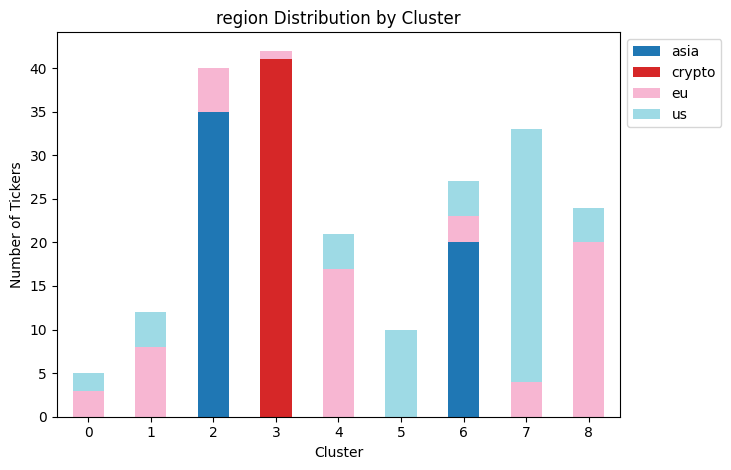

In [26]:
visualise_cryptos_in_clusters(region_dict, cluster_labels, 'kshape', just_cryptos=False, heatmap=False, file_name='full_clustering_market', class_name='region')

In [25]:
[v for k, v in cluster_labels['kshape'].items() if 'USDT' in k]

[3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3]

In [30]:
[k for k, v in cluster_labels['kshape'].items() if v == 3]

['SAN.PA',
 'BTCUSDT',
 'ETHUSDT',
 'XRPUSDT',
 'SOLUSDT',
 'DOGEUSDT',
 'ADAUSDT',
 'LINKUSDT',
 'XLMUSDT',
 'AVAXUSDT',
 'SHIBUSDT',
 'DOTUSDT',
 'LTCUSDT',
 'BCHUSDT',
 'UNIUSDT',
 'NEARUSDT',
 'ICPUSDT',
 'ETCUSDT',
 'AAVEUSDT',
 'RNDRUSDT',
 'ATOMUSDT',
 'MATICUSDT',
 'ALGOUSDT',
 'EOSUSDT',
 'MKRUSDT',
 'QNTUSDT',
 'STXUSDT',
 'INJUSDT',
 'GRTUSDT',
 'XTZUSDT',
 'CRVUSDT',
 'SANDUSDT',
 'ZECUSDT',
 'JASMYUSDT',
 'MANAUSDT',
 'AXSUSDT',
 'CHZUSDT',
 'COMPUSDT',
 '1INCHUSDT',
 'SNXUSDT',
 'ROSEUSDT',
 'LPTUSDT']

In [ ]:
def clustering_v_measure(cluster_dict:dict, class_dict:dict, method:str):
    methods_clusters = cluster_dict[method]

    common = list(set(methods_clusters) & set(class_dict))

    if not common:
        raise ValueError("No overlapping tickers between clustering and class dictionaries.")

    cluster_labels = [methods_clusters[t] for t in common]
    true_labels = [class_dict[t] for t in common]

    v_measure = v_measure_score(true_labels, cluster_labels)
    
    return v_measure